In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
from scipy.special import roots_legendre, eval_legendre
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import discretize
import  os
import json
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
import string
eps = np.finfo(float).eps

In [2]:
import empymod
from masa_utils import PsuedoLog
from masa_utils import Pelton_res_f, DDR_f
from masa_utils import InducedPolarizationSimulation 
from masa_utils import Optimization 
from masa_utils import empymod_IP_simulation
from masa_utils import TEM_Signal_Process


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019). On-Time: 200msec ramp time: 200usec Transmitter Loop: 3.5m Square Loop Receiver Loop: Coincident-type Number of Turn: 5 3.5m rectangular loop has equivalent area for 2.0m circular loop.

In [3]:

rmp_time=200e-6

smp_freq=50e3 #200e3  

In [4]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [5]:
tstrt, tend = 1e-4, 1e-2
logstep = 1/15
WISTEM_SP_sim = TEM_Signal_Process(
    # base_freq=base_freq,
    # on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq
)


In [6]:
times_sim = WISTEM_SP_sim.times_rec
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
windows_strt = WISTEM_SP_sim.windows_strt
windows_cen = WISTEM_SP_sim.windows_cen
windows_end = WISTEM_SP_sim.windows_end
print(windows_cen-rmp_time)

500
[2.e-05 4.e-05 6.e-05] [0.00996 0.00998 0.01   ]
[0.0001     0.00011659 0.00013594 0.00015849 0.00018478 0.00021544
 0.00025119 0.00029286 0.00034145 0.00039811 0.00046416 0.00054117
 0.00063096 0.00073564 0.0008577  0.001      0.00116591 0.00135936
 0.00158489 0.00184785 0.00215443 0.00251189 0.00292864 0.00341455
 0.00398107 0.00464159 0.0054117  0.00630957 0.00735642 0.00857696]


In [7]:
nlayer =1

rho0_target = 0.3
eta_target = 0.4
eta_sea , eta_base = 0.,0.
c_target = 0.5 
thick_target = 10.
tau_target = 100e-3

res_sea = 0.3
res_base = 1.0
tau_sea, tau_base, tau_ref = 1.0e-3, 1.0e-3, 1.0e-3
c_sea, c_base,  = c_target, c_target
tx_height = 0.1 #csx
depth = np.r_[0, thick_target]
depth+=tx_height
print(f"depth {depth}")

print(tx_height)

depth [ 0.1 10.1]
0.1


In [8]:
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

Window_mat = WISTEM_SP_sim.get_window_matrix(times_sim)
print(Window_mat.shape)

(30, 500)


In [9]:
recx, recy = 0 , 0
recBdple = [recx, recy, tx_depth ,0,90]
# recx, recy, recw = rec_area(3, tx_side)
# recBdple = [recx, recy, tx_depth ,0,90]

In [10]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_sim = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'res' : res,
    'freqtime': times_sim,
    'signal': None, # 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [11]:
sim_obs=empymod_IP_simulation(ip_model='pelton',
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    times=times_sim, smp_freq=smp_freq
    )
sim_obs.deepsea_signle_layer(
    res_sea=res_sea, res_base=res_base,
    eta_sea=eta_sea, eta_base=eta_base,
    tau_sea=tau_sea, tau_base=tau_base, 
    c_sea=c_sea, c_base=c_base
    )



In [12]:
print(sim_obs.m_fix)
print(sim_obs.model_base)

[-1.2039728   0.          0.          0.          0.          0.
 -6.90775528  0.         -6.90775528  0.5         0.          0.5       ]
{'src': [1.75, 1.75, 0, 1.75, 0, 0], 'rec': [0, 0, 0, 0, 90], 'depth': array([ 0.1, 10.1]), 'freqtime': array([2.00e-05, 4.00e-05, 6.00e-05, 8.00e-05, 1.00e-04, 1.20e-04,
       1.40e-04, 1.60e-04, 1.80e-04, 2.00e-04, 2.20e-04, 2.40e-04,
       2.60e-04, 2.80e-04, 3.00e-04, 3.20e-04, 3.40e-04, 3.60e-04,
       3.80e-04, 4.00e-04, 4.20e-04, 4.40e-04, 4.60e-04, 4.80e-04,
       5.00e-04, 5.20e-04, 5.40e-04, 5.60e-04, 5.80e-04, 6.00e-04,
       6.20e-04, 6.40e-04, 6.60e-04, 6.80e-04, 7.00e-04, 7.20e-04,
       7.40e-04, 7.60e-04, 7.80e-04, 8.00e-04, 8.20e-04, 8.40e-04,
       8.60e-04, 8.80e-04, 9.00e-04, 9.20e-04, 9.40e-04, 9.60e-04,
       9.80e-04, 1.00e-03, 1.02e-03, 1.04e-03, 1.06e-03, 1.08e-03,
       1.10e-03, 1.12e-03, 1.14e-03, 1.16e-03, 1.18e-03, 1.20e-03,
       1.22e-03, 1.24e-03, 1.26e-03, 1.28e-03, 1.30e-03, 1.32e-03,
       1.34e-03, 1.3

In [13]:

mvec_obs =  np.r_[np.log(rho0_target), eta_target, np.log(tau_target), c_target]
print(mvec_obs)
print(sim_obs.get_ip_model(mvec_obs))

[-1.2039728   0.4        -2.30258509  0.5       ]
{'res': array([0.3, 0.3, 1. ]), 'rho_0': array([0.3, 0.3, 1. ]), 'm': array([0. , 0.4, 0. ]), 'tau': array([0.001, 0.1  , 0.001]), 'c': array([0.5, 0.5, 0.5]), 'func_eta': <bound method empymod_IP_simulation.pelton_et_al of <masa_utils.empymod_IP_simulation object at 0x0000027231B66450>>}


In [14]:
sim_obs.cut_off = None
sim_obs.filt_curr = None
sim_obs.window_mat= None
dpred_step= sim_obs.dpred(mvec_obs)
sim_obs.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_obs.cut_off}")
dpred_LPF = sim_obs.dpred(mvec_obs)
sim_obs.filt_curr = filt_linrmp
dpred_rmp = sim_obs.dpred(mvec_obs)
sim_obs.window_mat=Window_mat
dpred_window = sim_obs.dpred(mvec_obs)

cutoff frequency: 25000.0


In [15]:
PL_decay = PsuedoLog(
    logmin=1e-8,
    linScale=1.0,
    logminx=1e-4,
    linScalex=0.2
    )
PL_filt = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )
PL_jac = PsuedoLog(
    logmin=1e-1,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.2
    )


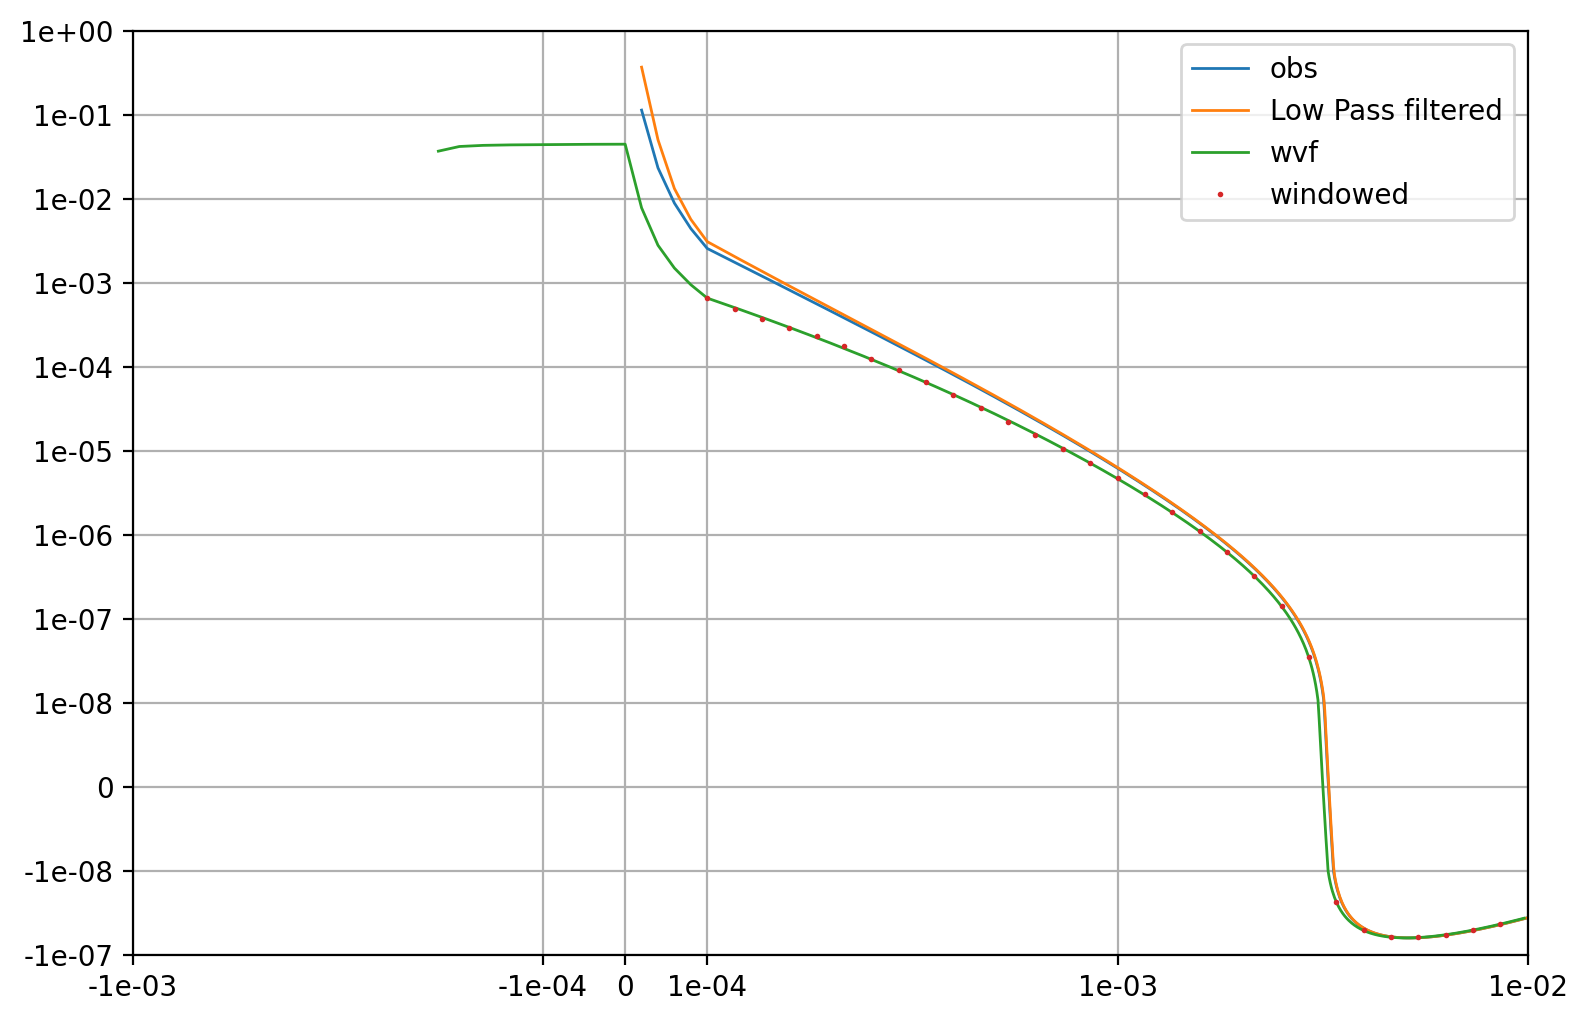

In [16]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [17]:
relative_error=0.05
data_noise_floor = 1e-8
dobs_clean =  sim_obs.dpred(mvec_obs)

# Calculate noise at each point according to the formula
np.random.seed(1)  # For reproducibility
noise_floor = data_noise_floor
noise_relative = relative_error * np.abs(dobs_clean)

# Combine the two sources of noise quadratically (in terms of variance)
total_noise = np.sqrt(noise_floor**2 + noise_relative**2)

# Add the combined noise to the clean data
dobs = dobs_clean +np.random.randn(len(dobs_clean)) *  total_noise
# data_init = sim_obs.predicted_data(mvec_ref)

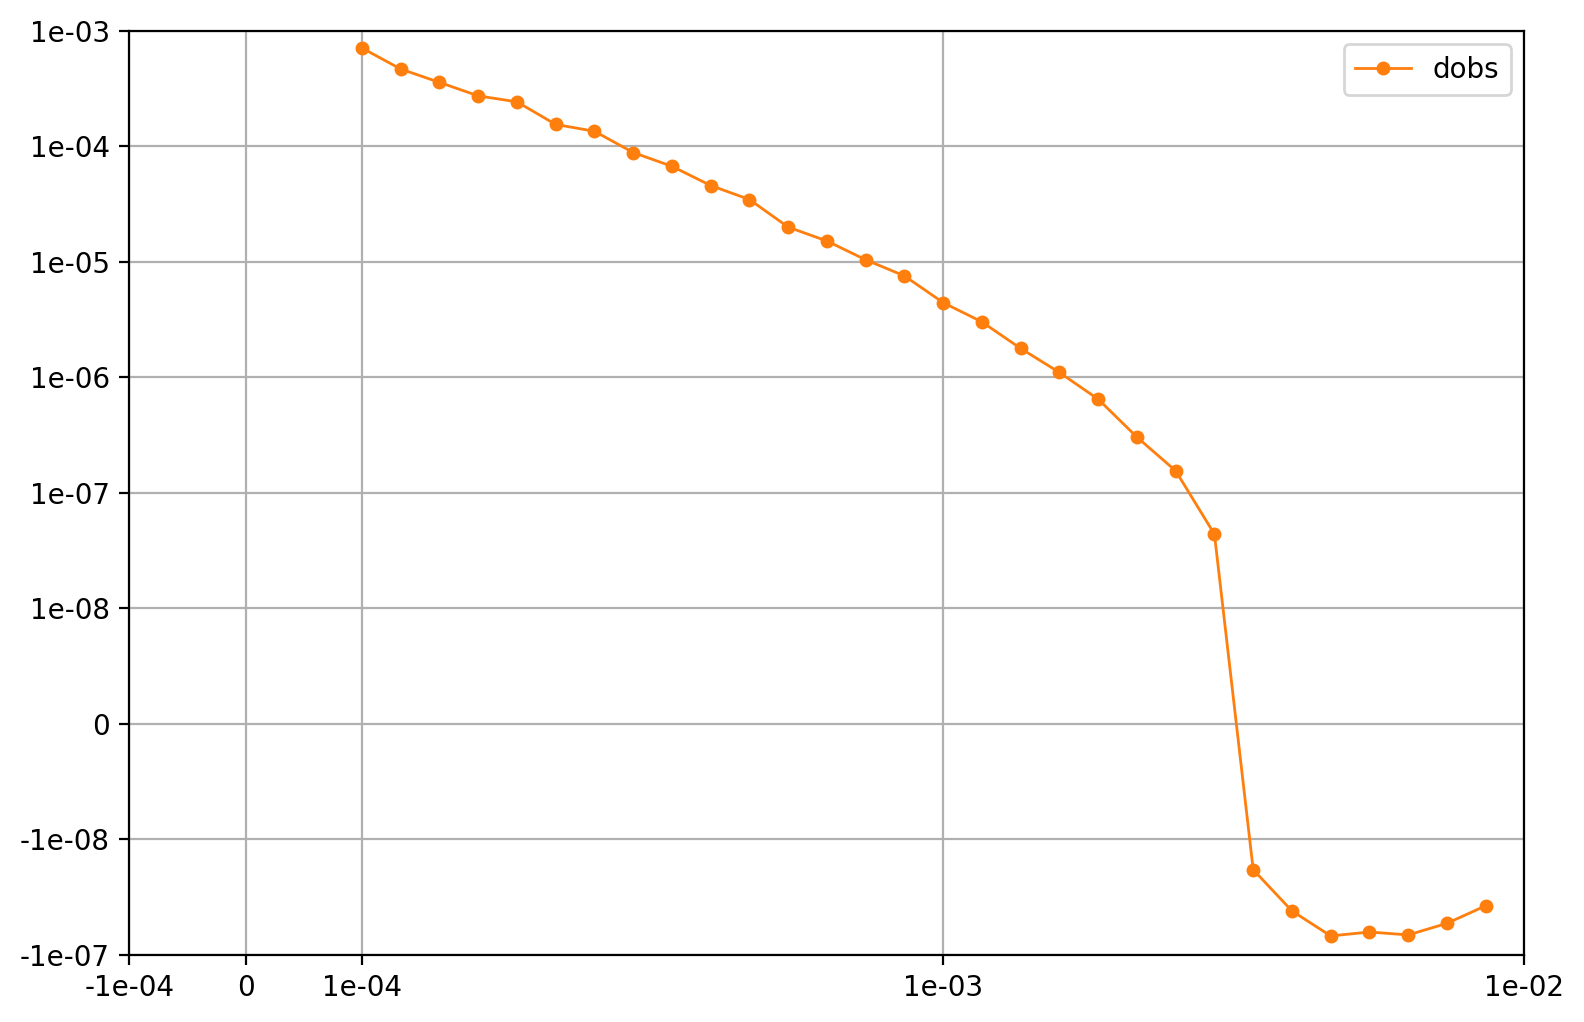

In [18]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)
# ax=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=data_init,
#    label="ref/init", color="C0", marker="o",markersize=4,ax=ax
# )
ax=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs, 
   label="dobs", color="C1", marker="o",markersize=4,ax=ax
)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


# Invert with Debye Decomposition model

In [19]:

nrange=3
taus_strt_log = -3.25*np.ones(nrange) # np.r_[-3.25, -3.25, -3.25]
# taus_strt_log = np.r_[-4.0, -4.0, -4.0]
# taus_end_log  = np.r_[-2.00, -1.75, -1.50]
taus_end_log  = np.r_[-2.75, -2.25, -1.25]
taus_end = 10**taus_end_log
taus_strt = 10**taus_strt_log
print(taus_end)
print(taus_strt)
taus_step_log = 0.25

taus_max, taus_min = taus_end_log.max(), taus_strt_log.min()


[0.00177828 0.00562341 0.05623413]
[0.00056234 0.00056234 0.00056234]


In [20]:

taus_cmb = []
m_refs = []
taus_colors = []
sim_inv = []
Wd_refs = []
J_refs = []
ntau_cmb= []
for i in range(nrange):
    ntau =  int((taus_end_log[i] - taus_strt_log[i])/taus_step_log) +1
    taus= np.logspace(taus_strt_log[i], taus_end_log[i], ntau, endpoint=True)

    taus_color = (np.linspace(taus_strt_log[i], taus_end_log[i], ntau)-taus_min)/ (taus_max-taus_min)
    m_ref = np.r_[np.log(res_sea), np.zeros(ntau)]
    print(taus) 
    print(taus_color)
    taus_cmb.append(taus)
    ntau_cmb.append(ntau)
    taus_colors.append(taus_color)
    m_refs.append(m_ref)
    sim=empymod_IP_simulation(ip_model='DDR',chgmin=0,
        model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
        taus=taus, times=times_sim, smp_freq=smp_freq
    )
    sim.deepsea_signle_layer(
        res_sea=res_sea, res_base=res_base, eta_sea=eta_sea, eta_base=eta_base  
        )
    dpred_step= sim.dpred(m_ref)
    sim.cut_off = smp_freq/2.0
    dpred_LPF = sim.dpred(m_ref)
    sim.filt_curr = filt_linrmp
    dpred_rmp = sim.dpred(m_ref)
    sim.window_mat=Window_mat
    dpred_window = sim.dpred(m_ref)
    sim_inv.append(sim) 
    opt = Optimization(sim=sim_inv[i], dobs=dpred_window)
    opt.get_Wd(ratio=relative_error, plateau=data_noise_floor )
    Wd_refs.append(opt.Wd)
    J_refs.append(sim_inv[i].J(m_ref))
Wd_ref = Wd_refs[0]
ntau_max = max(ntau_cmb)

[0.00056234 0.001      0.00177828]
[0.    0.125 0.25 ]
[0.00056234 0.001      0.00177828 0.00316228 0.00562341]
[0.    0.125 0.25  0.375 0.5  ]
[0.00056234 0.001      0.00177828 0.00316228 0.00562341 0.01
 0.01778279 0.03162278 0.05623413]
[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


In [21]:
taus_colors

[array([0.   , 0.125, 0.25 ]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  ]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])]

In [22]:
U_ddr_refs = []
U_ddr_recs = []
S_ddr_refs = []
S_ddr_recs = []
V_ddr_refs = []
V_ddr_recs = []
Jprd_refs = []
Jprd_recs = []
J_refs = []
J_recs = []
for i in range(nrange):
    sim = sim_inv[i]
    Wd_ref = Wd_refs[i]
    m_ref = m_refs[i]
    jacobian = sim.J(m_ref)
    J_refs.append(jacobian)
    U, S, V = np.linalg.svd(Wd_ref@jacobian, full_matrices=False)
    U_ddr_refs.append(U)
    V_ddr_refs.append(V)
    s_norm = S/S.max()
    S_ddr_refs.append(s_norm)
    Jprd = sim.J_prd(Wd_ref@jacobian)
    Jprd_refs.append(abs(Jprd))

sim = sim_obs
jacobian = sim_obs.J(mvec_obs)
J_refs.append(jacobian)
U, S, V = np.linalg.svd(Wd_ref@jacobian, full_matrices=False)
U_ddr_refs.append(U)
V_ddr_refs.append(V)
s_norm = S/S.max()
S_pelton = s_norm
Jprd = sim_obs.J_prd(Wd_ref@jacobian)
Jprd_pelton = abs(Jprd)



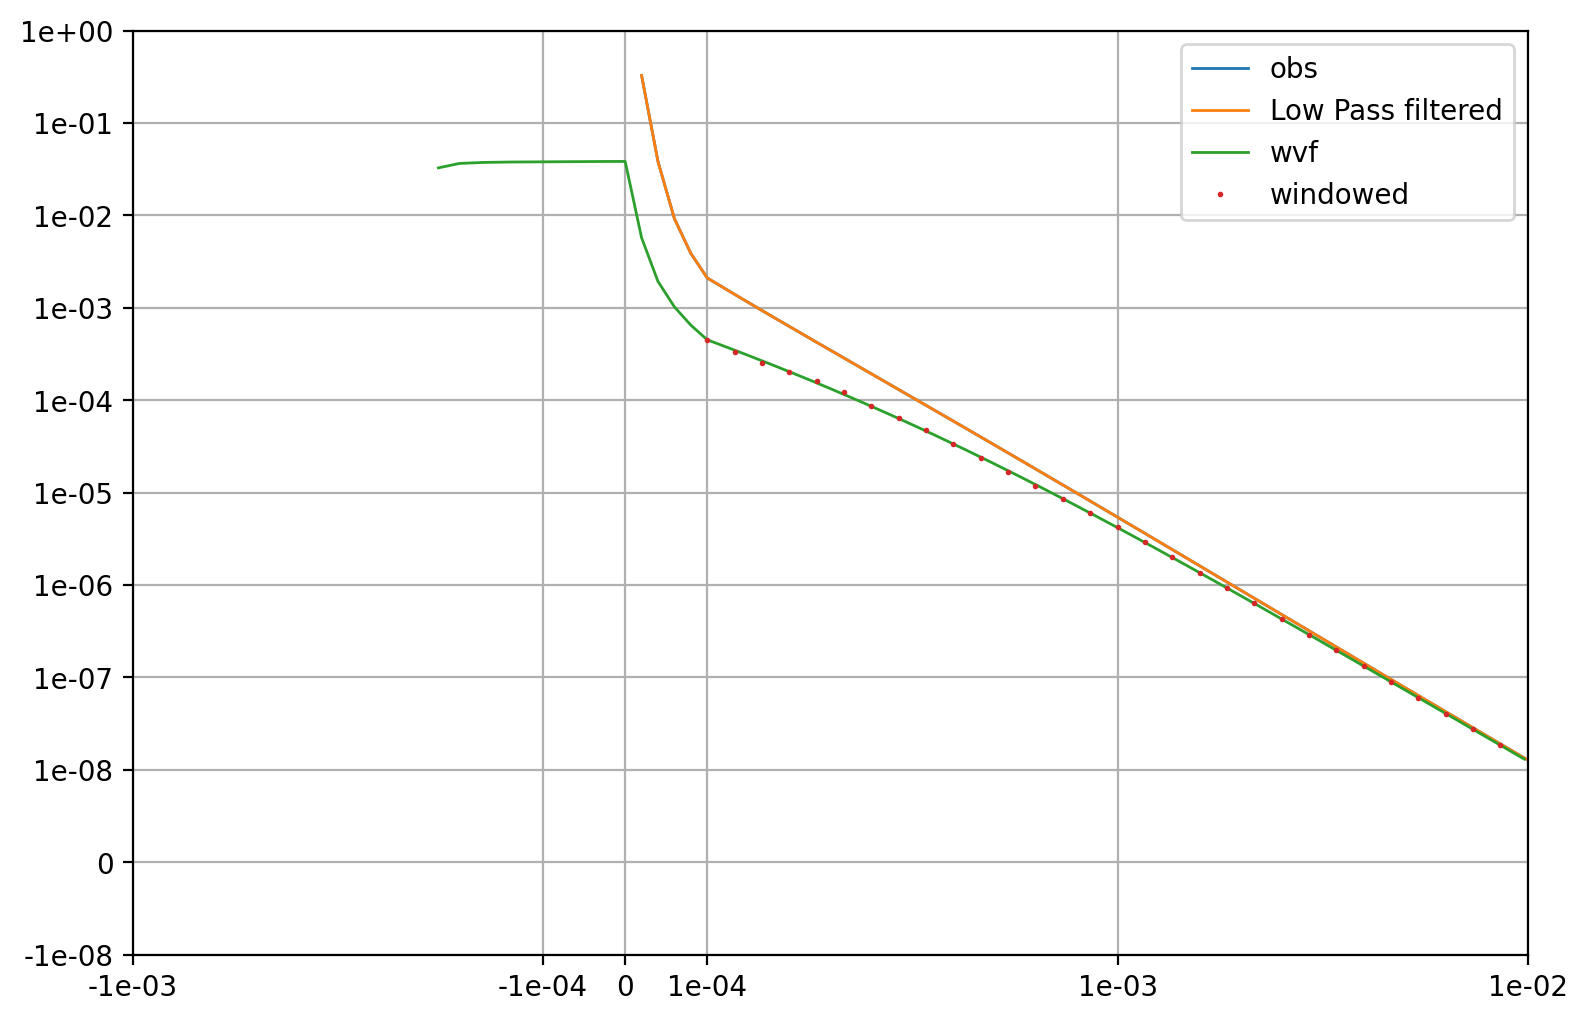

In [23]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [24]:
colormap = plt.get_cmap("cool")

In [25]:
def plot_data(data_init, dpred, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data_init, ax=ax,
                       color="C1",label="ref" #
                       )
    ax=PL_decay.semiply(windows_cen-rmp_time, dpred, ax=ax
                        ,color="C0",linestyle="-",
                        label=f"est"# mated, iter={iteration}"
                        )
    ax=PL_decay.semiply(windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=2.0,
                       color="C3",linestyle="", label="obs"
                       )
    ax = PL_decay.pl_axes(ax)
    # ax.grid()
    # ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")

#     ax.set_title(f""" Data plot
# Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e}""")
    return ax

In [60]:
def sci_latex(v, prec=2):
    if v == 0:
        return "0"
    s = f"{v:.{prec}e}"      # e.g. '3.0e-03'
    mant, exp = s.split('e')
    exp = int(exp)           # -3, 0, 5, etc.

    if exp == 0:
        return mant
    return rf"{mant}\cdot 10^{{{exp}}}"


In [61]:
def plot_jacobian(irange, indbold=None,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    taus = taus_cmb[irange]
    taus_color = taus_colors[irange]
    ntau = ntau_cmb[irange]
    J_ref = J_refs[irange]
    Wd_ref = Wd_refs[irange]
    for j in range(ntau):
        color = colormap(taus_color[j])
        linewidth = 1
        linestyle ='-'
        if j == indbold:
            linewidth = 2.5
            linestyle ='--'
        label = rf"$\eta_{{{j+1}}}, \tau_{{{j+1}}}: {sci_latex(taus[j], prec=1)}$"

        ax = PL_jac.semiply(
            x=windows_cen - rmp_time,
            y=Wd_ref @ J_ref[:, j + nlayer],
            color=color,
            linestyle=linestyle,
            label=label,
            linewidth=linewidth,
            ax=ax
        )

    ax=PL_jac.semiply(
        windows_cen-rmp_time, Wd_ref@J_ref[:,0],color="k",label=r"+$\rho_0$",ax=ax,
            linestyle="--", linewidth=2#, marker="o",markersize=4
            )

    ax=PL_jac.semiply(
        windows_cen-rmp_time, -Wd_ref@J_ref[:,0],color="k",label=r"-$\rho_0$",ax=ax,
            linestyle="-.", linewidth=2#, marker="o",markersize=4
            )
    ax= PL_jac.pl_axes(ax)
    ax.set_xlabel("Time (s)")
    ax.set_title(fr"$W_dJ$ for $\tau_k$ band_{irange+1}")
    return ax

In [62]:
def plot_jacobian_unit(irange, indbold=None,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    taus = taus_cmb[irange]
    taus_color = taus_colors[irange]
    ntau = ntau_cmb[irange]
    J_ref = J_refs[irange]
    Wd_ref = Wd_refs[irange]
    for j in range(ntau):
        color = colormap(taus_color[j])
        linewidth = 1
        linestyle ='-'
        if j == indbold:
            linewidth = 2.5
            linestyle ='--'
        label = rf"$\eta_{{{j+1}}}, \tau_{{{j+1}}}: {sci_latex(taus[j], prec=1)}$"

        ax.semilogx(
            windows_cen - rmp_time,
            Wd_ref @ J_ref[:, j + nlayer]/np.linalg.norm(Wd_ref @ J_ref[:, j + nlayer]),
            color=color,
            linestyle=linestyle,
            label=label,
            linewidth=linewidth,

        )

    ax.semilogx(
        windows_cen-rmp_time, 
        Wd_ref@J_ref[:,0]/np.linalg.norm(Wd_ref@J_ref[:,0]),
        color="k",label=r"+$\rho_0$",
            linestyle="--", linewidth=2#, marker="o",markersize=4
            )

    ax.semilogx(
        windows_cen-rmp_time, 
        -Wd_ref@J_ref[:,0]/np.linalg.norm(Wd_ref@J_ref[:,0]),
        color="k",label=r"-$\rho_0$",
            linestyle="-.", linewidth=2#, marker="o",markersize=4
            )
    ax= PL_jac.pl_axes(ax)
    ax.set_xlabel("Time (s)")
    ax.set_title(fr"$W_dJ$ for $\tau_k$ band_{irange+1}")
    return ax

In [63]:
def plot_taus(irange,ax=None):
    if ax is None:
        fig , ax = plt.subplots(1,1, figsize=(5,3))

    taus = taus_cmb[irange]
    taus_color = taus_colors[irange]
    ntau = ntau_cmb[irange]
    for j in range(ntau):
        color = colormap(taus_color[j])
        ax.semilogx(taus[j], irange, 
            linestyle="", marker="o", color=color, markersize=4.0)
    ax.set_yticks(np.arange(0, nrange))
    ax.set_yticklabels([fr"$\tau_k$ band_{i+1}" for i in range(nrange)])
    ax.invert_yaxis()
    ax.set_title(r"$\tau_k$ for each model")
    ax.set_xlabel(r"$\tau_k$ (s)")
    return ax

In [64]:
def plot_cnd(S,ax=None, label=None):
    if ax is None:
        fig , ax = plt.subplots(1,1, figsize=(5,3))
    ax.semilogy(S, linestyle="-", marker="o",
                   label=label) # max($\tau_j$): {tau_end:.2e}")
    ax.set_xticks(np.arange(ntau_max+1))
    ax.set_xticklabels(np.arange(1,ntau_max+2))
    ax.set_xlabel("Singular Value Index")
    ax.set_title("Condition Number")

    return ax

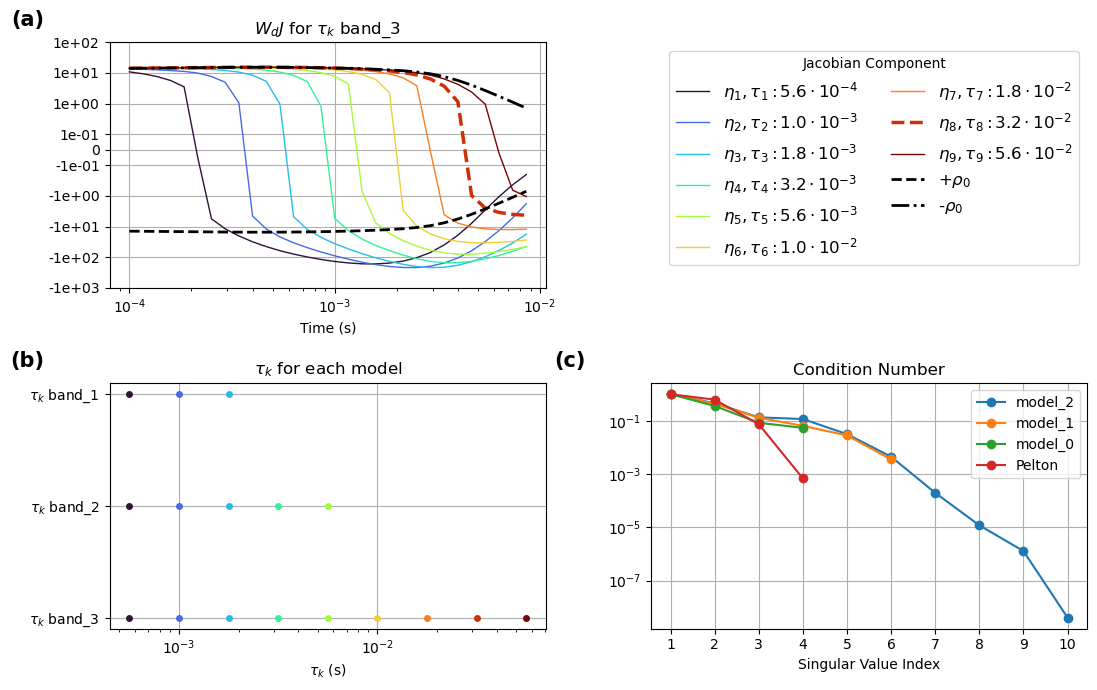

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(11,7))
ax_jacobian = ax[0, 0]
ax_cnd = ax[1, 1]
ax_tau = ax[1, 0]
ax_color =ax[0, 1]

taus = taus_cmb[2]
ntau = ntau_cmb[2]

ax_jacobian =  plot_jacobian(irange=2, indbold=7, ax=ax_jacobian)
for i in range(nrange-1,-1,-1):
    ax_cnd=plot_cnd(S_ddr_refs[i], ax=ax_cnd, label= f"model_{i}")
    ax_tau=plot_taus(irange=i, ax=ax_tau)
ax_cnd = plot_cnd(S_pelton, ax=ax_cnd, label="Pelton")

# ax_color=plot_color(ax=ax_color)

for a in ax.flatten():
    a.grid()

ax_cnd.legend()
ax_color.axis("off")
handles, labels = ax_jacobian.get_legend_handles_labels()
ax_color.legend(handles, labels, title="Jacobian Component",loc="upper right",ncol=2, fontsize=12)

axis_to_label = [ax_jacobian,ax_tau,ax_cnd]
panel_labels = ['(a)', '(b)', '(c)']
ax = ax.flatten()

for label, axis in zip(panel_labels, axis_to_label):
    axis.text(
        -0.15, 1.05, label,
        transform=axis.transAxes,
        fontsize=15, fontweight='bold',
        va='bottom', ha='right'
    )

plt.tight_layout()
#plt.savefig('43_DD_TEM_Jacobian.jpg', dpi=300)#

In [66]:
colormap = plt.get_cmap("turbo")

Text(0.05496913580246915, 0.4426527777777777, '(c)')

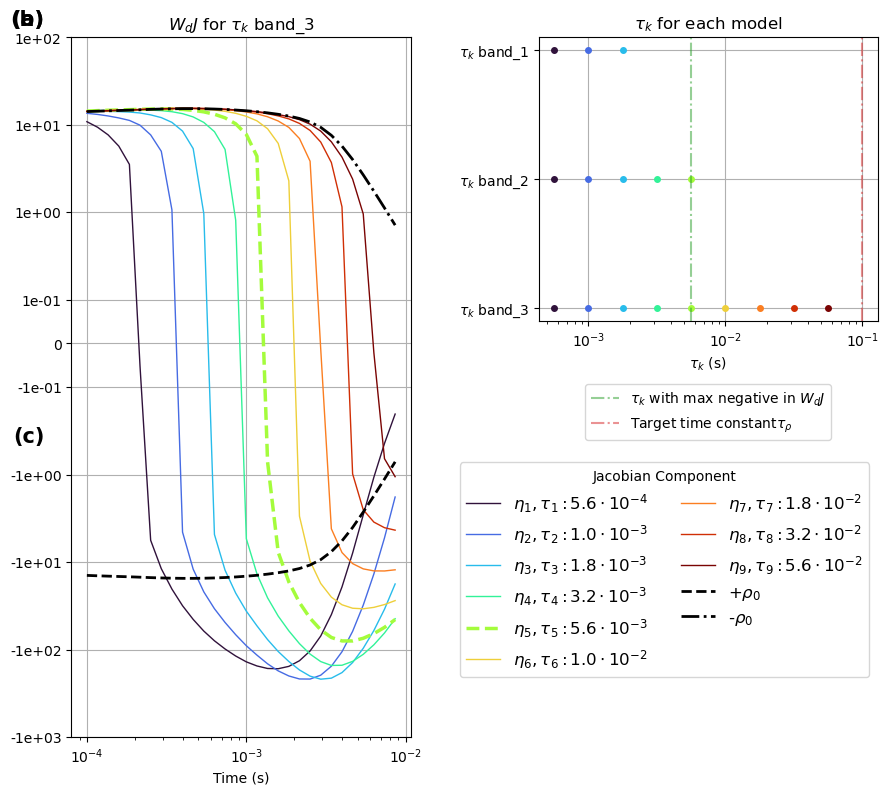

In [ ]:
fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2, 2) 
ax_jacobian = fig.add_subplot(gs[:,0 ])
ax_tau = fig.add_subplot(gs[0, 1])
ax_color = fig.add_subplot(gs[1, 1])

taus = taus_cmb[2]
ntau = ntau_cmb[2]
indbold = 4
ax_jacobian =  plot_jacobian(irange=2, indbold=indbold, ax=ax_jacobian)
for i in range(nrange-1,-1,-1):
    ax_tau=plot_taus(irange=i, ax=ax_tau)
x= taus[indbold]
ax_tau.axvline(x=x, color='C2', linestyle='-.', 
        alpha=0.5,label = r"$\tau_k$ with max negative in $W_dJ$")
ax_tau.axvline(x=tau_target, color='C3', linestyle='-.', 
        alpha=0.5,label = r"Target time constant$\tau_\rho$")

ax_tau.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=1)

for a in [ax_jacobian, ax_tau]:
    a.grid()


ax_color.axis("off")
handles, labels = ax_jacobian.get_legend_handles_labels()
ax_color.legend(handles, labels, title="Jacobian Component",loc="upper right",ncol=2, fontsize=12)

ffig.tight_layout()
fig.canvas.draw()

labels_axes = [
    ('(a)', ax_jacobian),
    ('(b)', ax_tau),
    ('(c)', ax_color),
]

for lab, ax in labels_axes:
    pos = ax.get_position()
    fig.text(
        pos.x0 - 0.02,     # left of THIS axis
        pos.y1 + 0.01,     # above THIS axis
        lab,
        fontsize=15, fontweight='bold',
        ha='right', va='bottom'
    )

# fig.subplots_adjust(hspace=0.40)
# plt.savefig('43_DD_TEM_Jacobian.jpg', dpi=300)#
# plt.savefig('43_DD_TEM_Jacobian.pdf', dpi=300, bbox_inches="tight")

In [57]:
print(ax_jacobian.get_position(), ax_tau.get_position(), ax_cnd.get_position())

Bbox(x0=0.10617424242424242, y0=0.07859722222222221, x1=0.47231631777505023, y1=0.9177499999999998) Bbox(x0=0.614762994072899, y0=0.581486111111111, x1=0.9809050694237069, y1=0.9177499999999998) Bbox(x0=0.589375, y0=0.0946825396825397, x1=0.9863636363636363, y1=0.4456428571428571)


# Inversion: Single layer fixed thickness

In [34]:
niter = 50
stol=1e-6
coolingFactor = 2 #np.sqrt(2) #2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0
alphas= 1.0
Ws_threshold=0.1

In [35]:
models_rec = []
dpreds = []
error_prgs = []
model_prgs = []
dinit_refs = []
data_prgs =[]
betas_prgs = []
for i in range(nrange):
    m_ref = m_refs[i]
    sim = sim_inv[i]
    opt = Optimization(sim=sim, dobs=dobs, alphas=alphas, Ws_threshold=Ws_threshold)
    opt.get_Wd(ratio=relative_error, plateau=data_noise_floor )
    opt.get_Ws(smallness=np.ones(len(m_ref)))
    beta0 = opt.BetaEstimate_byEig(
        mvec=m_ref, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GaussNewton(
    mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
    stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
    )
    
    dinit_refs.append(opt.dpred(m_ref))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    error_prgs.append(opt.error_prg)
    model_prgs.append(opt.mvec_prg)
    data_prgs.append(opt.data_prg)
    betas_prgs.append(opt.betas)


149124328.29660597
  1, beta:1.5e+08, step:1.0e+00, g:5.6e+04, phid:3.2e+03, phim:8.1e-08, f:3.2e+03 
  2, beta:1.5e+08, step:9.5e-07, g:3.5e+01, phid:3.2e+03, phim:8.1e-08, f:3.2e+03 
  3, beta:7.5e+07, step:1.0e+00, g:2.8e+04, phid:3.1e+03, phim:3.2e-07, f:3.2e+03 
  4, beta:7.5e+07, step:9.5e-07, g:3.2e+01, phid:3.1e+03, phim:3.2e-07, f:3.2e+03 
  5, beta:3.7e+07, step:1.0e+00, g:2.7e+04, phid:3.1e+03, phim:1.2e-06, f:3.1e+03 
  6, beta:3.7e+07, step:9.5e-07, g:5.9e+01, phid:3.1e+03, phim:1.2e-06, f:3.1e+03 
  7, beta:1.9e+07, step:1.0e+00, g:2.7e+04, phid:2.9e+03, phim:4.3e-06, f:3.0e+03 
  8, beta:1.9e+07, step:9.5e-07, g:9.8e+01, phid:2.9e+03, phim:4.4e-06, f:3.0e+03 
  9, beta:9.3e+06, step:1.0e+00, g:2.6e+04, phid:2.6e+03, phim:1.5e-05, f:2.8e+03 
 10, beta:9.3e+06, step:9.5e-07, g:1.5e+02, phid:2.6e+03, phim:1.5e-05, f:2.8e+03 
 11, beta:4.7e+06, step:1.0e+00, g:2.4e+04, phid:2.3e+03, phim:4.3e-05, f:2.5e+03 
 12, beta:4.7e+06, step:1.0e+00, g:2.5e+02, phid:2.3e+03, phim:4.4e-

In [36]:
phid_star=len(windows_cen)
models_rec_phid = []
dpreds_phid = []
phid_star_ratio =1.1
phid_itrs = []
chis = []
for i in range(nrange):
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        print(f" range {i}:No phid star found, take min phid")
        ind = phid_prg == np.min(phid_prg)
    phid = phid_prg[ind][0]
    phid_itr = np.where(ind)[0][0]
    models_rec_phid.append(model_prg[ind][0])
    dpreds_phid.append(data_prg[ind][0])
    phid_itrs.append(phid_itr)
    chis.append(phid/phid_star)

 range 0:No phid star found, take min phid


In [37]:
chis

[np.float64(6.5569618822893085),
 np.float64(1.035225973406911),
 np.float64(1.0630027645565459)]

In [38]:
print( "Parameter:  $\\rho_0$, $\\eta$, $\\tau_max$")
np_mvec_refs= []
np_mvec_ests= []
for i in range(nrange):
    np_mvec_ref = m_refs[i]
    # mvec_est = models_rec[i]
    mvec_est = models_rec_phid[i]
    taus_max = taus_cmb[i].max()
    np_mvec_refs.append(np_mvec_ref)
    np_mvec_ests.append(mvec_est)
    # print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    # print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f} & {taus_max:.2e}")
    print(f"est_phid{i+1}& {np.exp(mvec_est[0]):.2e} & {mvec_est[1:].sum():.3f} & {taus_max:.2e}")


Parameter:  $\rho_0$, $\eta$, $\tau_max$
est_phid1& 2.18e-01 & 0.059 & 1.78e-03
est_phid2& 2.23e-01 & 0.112 & 5.62e-03
est_phid3& 2.88e-01 & 0.312 & 5.62e-02


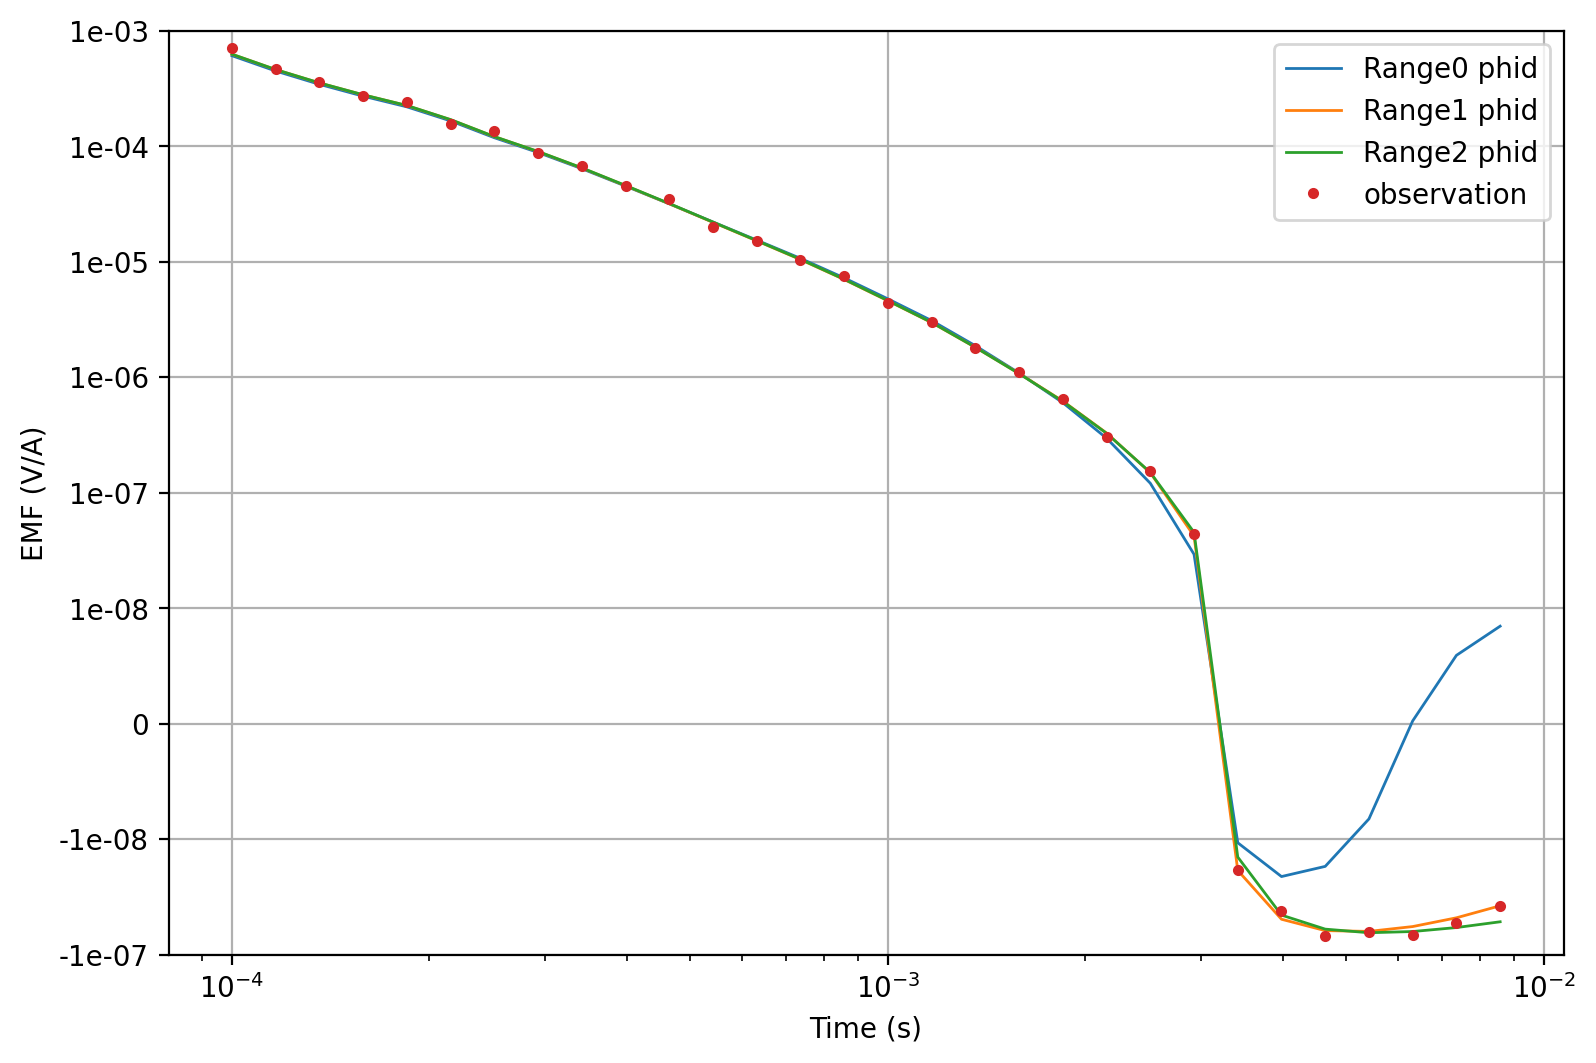

In [39]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)
for i in range(nrange):
    # ax=PL_decay.semiply(
    #     windows_cen-rmp_time, dpreds[i], ax=ax,
    #     color=f"C{i}",linestyle="-", label=f"Ref/Init{i+1}"
    #     )
    ax = PL_decay.semiply(
        windows_cen-rmp_time, dpreds_phid[i], ax=ax,
        color=f"C{i}",linestyle="-", label=f"Range{i} phid"
        )
ax=PL_decay.semiply(
    windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=3.0,
    color=f"C{nrange}",linestyle="", label="observation"
    )
ax = PL_decay.pl_axes(ax)
ax.grid()
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("EMF (V/A)")
plt.savefig("43_DD_TEM_dpreds_10msec.jpg", dpi=300)

# get SIP of target layer

In [40]:
freq_step_log  = 0.1
freq_cmb = []
freq_mins = []
freq_maxs = []
for i in range(nrange):

    nfreq = int((taus_end_log[i] - taus_strt_log[i])/freq_step_log) +1
    freq = np.logspace(
        -taus_end_log[i], -taus_strt_log[i], nfreq, endpoint=True
        ) 
    # freq = 10**np.arange(-taus_end_log[i], -taus_strt_log[i]+freq_step_log, freq_step_log)
    freq /= 2.0*np.pi
    freq_cmb.append(freq)
    freq_mins.append(freq.min())
    freq_maxs.append(freq.max())
    print(f"Range {i}: nfreq {nfreq}, freq min {freq.min():.2e}, max {freq.max():.2e}")


Range 0: nfreq 6, freq min 8.95e+01, max 2.83e+02
Range 1: nfreq 11, freq min 2.83e+01, max 2.83e+02
Range 2: nfreq 21, freq min 2.83e+00, max 2.83e+02


In [41]:
freq_ext = 10.**np.arange(-1,5.1,0.1)   
IP_model = Pelton_res_f(freq=freq_ext)
sim_sip_pel_ext = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')



In [42]:
noise_floor_ratio = 1e-2
niter = 100
stol=1e-6
coolingFactor = 2 # np.sqrt(2) 
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [43]:
sip_trues =[]
sim_sip = []
sim_sip_pelton = []
sip_dpreds = []
model_recs_sip = []
dpreds_sip = []
error_prgs_sip = []
model_prgs_sip = []
dinit_refs_sip = []
data_prgs_sip =[]
betas_prgs_sip = []
for i in range(nrange):
    freq = freq_cmb[i]
    nfreq = len(freq)

    IP_model = Pelton_res_f(freq=freq)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sim_sip_pelton.append(sim)
    dobs_sip = sim.dpred(m=mvec_obs)
    sip_trues.append(dobs_sip)
    f_abs = abs(IP_model.f(mvec_obs))
    noise_floor= f_abs.max()*noise_floor_ratio

    taus = taus_cmb[i]
    ntau = ntau_cmb[i]

    IP_model = DDR_f(freq=freq,taus=taus)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sim_sip.append(sim)
    sip_dpreds.append(sim.dpred(models_rec_phid[i]))
    
    mvec_ref = m_refs[i]
    opt = Optimization(sim=sim, dobs= dobs_sip)
    opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.get_Ws(np.ones(len(mvec_ref)))
    beta0 = opt.BetaEstimate_byEig(mvec=mvec_ref, update_Wsen=True)
    mpred = opt.GaussNewton(
        mvec_init=mvec_ref,niter=niter,beta0=beta0, update_Wsen=True,
        stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
        )
    dinit_refs_sip.append(opt.dpred(mvec_ref))
    model_recs_sip.append(mpred)
    dpreds_sip.append(opt.dpred(mpred))
    error_prgs_sip.append(opt.error_prg)
    model_prgs_sip.append(opt.mvec_prg)
    data_prgs_sip.append(opt.data_prg)
    betas_prgs_sip.append(opt.betas)


  1, beta:4.7e+05, step:1.0e+00, g:5.1e+03, phid:7.3e+02, phim:8.5e-05, f:7.7e+02 
  2, beta:4.7e+05, step:1.2e-01, g:8.3e+01, phid:7.3e+02, phim:8.4e-05, f:7.7e+02 
  3, beta:2.3e+05, step:1.0e+00, g:2.0e+03, phid:6.2e+02, phim:2.6e-04, f:6.8e+02 
  4, beta:2.3e+05, step:1.2e-01, g:6.1e+01, phid:6.2e+02, phim:2.6e-04, f:6.8e+02 
  5, beta:1.2e+05, step:1.0e+00, g:1.7e+03, phid:4.7e+02, phim:7.2e-04, f:5.6e+02 
  6, beta:1.2e+05, step:1.2e-01, g:7.2e+01, phid:4.7e+02, phim:7.1e-04, f:5.6e+02 
  7, beta:5.9e+04, step:1.0e+00, g:1.3e+03, phid:3.2e+02, phim:1.7e-03, f:4.2e+02 
  8, beta:5.9e+04, step:1.2e-01, g:6.8e+01, phid:3.2e+02, phim:1.7e-03, f:4.2e+02 
  9, beta:2.9e+04, step:1.0e+00, g:9.5e+02, phid:1.9e+02, phim:3.4e-03, f:2.9e+02 
 10, beta:2.9e+04, step:1.2e-01, g:5.2e+01, phid:1.9e+02, phim:3.3e-03, f:2.9e+02 
 11, beta:1.5e+04, step:1.0e+00, g:6.3e+02, phid:9.6e+01, phim:5.7e-03, f:1.8e+02 
 12, beta:1.5e+04, step:1.2e-01, g:3.2e+01, phid:9.6e+01, phim:5.6e-03, f:1.8e+02 
 13,

In [44]:
phid_star_ratio = 1.1
sip_true_inv = []
sip_true_dpred = []
for i in range(nrange):
    sim = sim_sip[i]
    freq = freq_cmb[i]
    taus = taus_cmb[i]
    nfreq = freq.shape[0]
    phid_star = nfreq*2
    model_prg= np.array(model_prgs_sip[i])
    data_prg = np.array(data_prgs_sip[i])
    error_prg = error_prgs_sip[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
        print(f" range {i}:No phid star found, take min phid")
    sip_true_inv.append(model_prg[ind][0])
    model = model_prg[ind][0]
    sip_true_dpred.append(data_prg[ind][0])
    rho0_sip = np.exp(model[0])
    eta_sip = model[1:].sum()
    print(f"Model {i}: rho0: {rho0_sip:.2e}, eta: {eta_sip:.3f}")
 

Model 0: rho0: 2.08e-01, eta: 0.084
Model 1: rho0: 2.25e-01, eta: 0.130
Model 2: rho0: 2.58e-01, eta: 0.252


In [45]:
# def plot_sip(freq, dpreds, ax=None, **kwargs):
#     if ax is None: 
#         fig, ax = plt.subplots(2, 1, figsize=(5,3))
#     nfreq = len(freq)

#     default_kwargs = {
#         "linestyle": "-",
#         "color": "C0",
#         "linewidth": 1.0,
#         "marker": None,
#         "markersize": 1,
#     }
#     default_kwargs.update(kwargs)
#     nfreq = len(dpreds)//2

#     sip_real = dpreds[:nfreq]
#     sip_imag = dpreds[nfreq:]
#     sip_abs = np.abs(sip_real + 1j * sip_imag)
#     sip_phs = np.angle(sip_real + 1j * sip_imag, deg=True)
#     ax[0].semilogx(freq, sip_abs, **default_kwargs)
#     ax[1].semilogx(freq, sip_phs, **default_kwargs)

#     ax[0].set_ylim(bottom=0)
#     ax[0].set_ylabel(r'$|\rho^{\ast}|~(\Omega\cdot\mathrm{m})$')
#     ax[1].set_ylabel(r'$\phi~(^\circ)~(\mathrm{deg}) $')
#     for a in ax:
#         a.set_xlabel("Frequency [Hz]")

#     return ax

In [46]:
def plot_etas_model(model,taus, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    etas = model[1:]

    ax.semilogx(taus, etas, **kwargs)
    ax.set_xlabel(r"$\tau_k$ [s]")
    ax.set_ylabel(r"$\eta_k$")
    return ax

In [47]:
# title_heads= ['model_1', 'model_2', 'model_3']
# title_heads = []
# for i in range(nrange):
#     title_head = fr'$max(\tau_k)$: {taus_end[i]:.1e}'
#     title_heads.append(title_head)
title_heads = [r"$\tau_k$ band_1", r"$\tau_k$ band_2", r"$\tau_k$ band_3"]

print(title_heads)
column_labels = ["1", "2", "3"]

['$\\tau_k$ band_1', '$\\tau_k$ band_2', '$\\tau_k$ band_3']


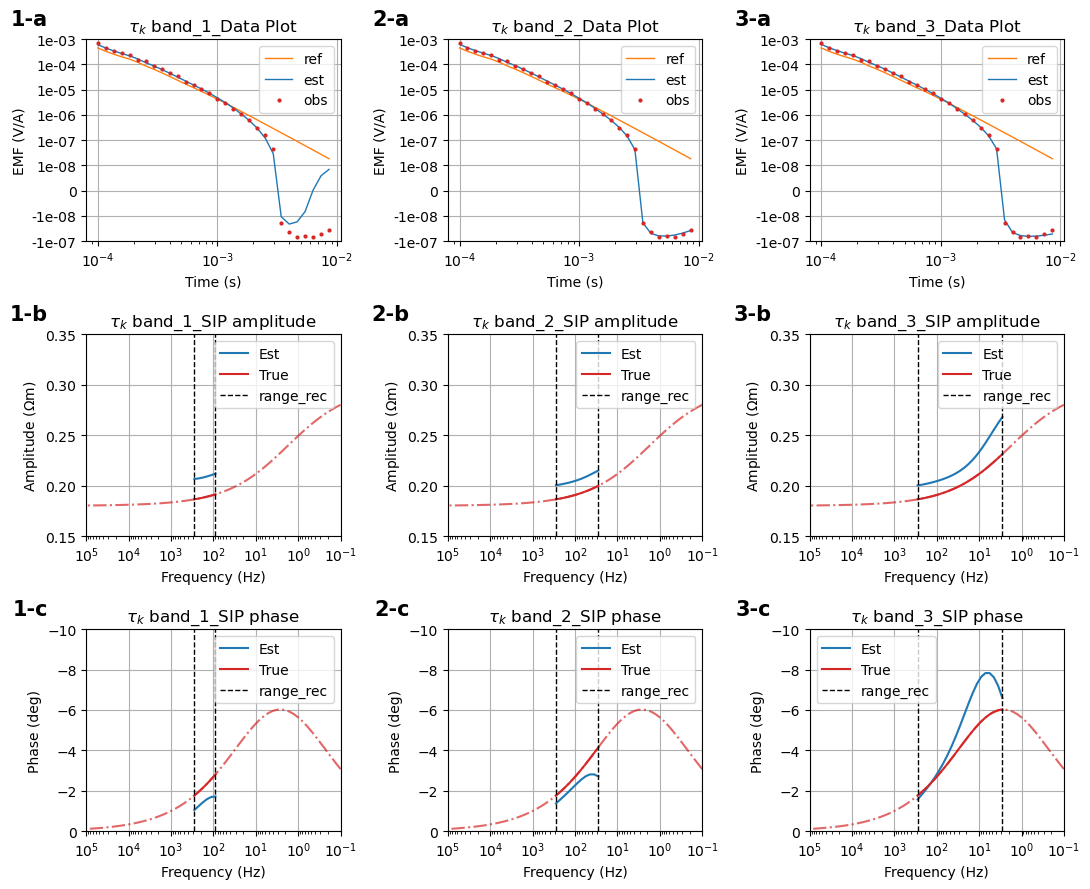

In [48]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nrange):
    title_head= title_heads[i]
    phid_itr = phid_itrs[i]
    model = models_rec_phid[i]
    sim = sim_sip[i]
    sim_pelton = sim_sip_pelton[i]
    ax_range = ax_ranges[i]
    axdata = ax_range[0]
    axsip = [ax_range[1], ax_range[2]]
    axdata = plot_data(data_init = dinit_refs[i], dpred=dpreds_phid[i], ax=axdata)

    axsip = sim_sip_pel_ext.plot_sip_model(model=mvec_obs, ax=axsip,
            color="C3", linestyle="-.", alpha=0.7)
    axsip = sim.plot_sip_model(model=model, ax=axsip,
            color="C0", label=f"Est", linestyle="-")

    axsip = sim_pelton.plot_sip_model(model=mvec_obs, ax=axsip,
            color="C3", label=f"True", linestyle="-")
    
    # axsip = plot_sip(freq_cmb[i], sip_dpreds[i], 
    #          ax=axsip, color="C0", label=f"Estimated", linestyle="-"
    #          )
    # axsip  = plot_sip(freq=freq_ext,
    #           dpreds=sip_true_ext,ax=axsip, color="C2", label=f"True", linestyle="-.",
    #           alpha=0.7
    #           )
    # axsip  = plot_sip(freq=freq_cmb[i],
    #           dpreds=sip_trues[i],ax=axsip, color="C2", label=f"True_FB", linestyle=":",
    #           linewidth=2.0)
    axsip[0].set_ylim(bottom=0.15,top=0.35)
    axsip[1].set_ylim(top=-10, bottom=0)
    axsip[0].axvline(x=freq_mins[i], color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[0].axvline(x=freq_maxs[i], color='k', linestyle='--', linewidth=1.0)
    axsip[1].axvline(x=freq_mins[i], color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[1].axvline(x=freq_maxs[i], color='k', linestyle='--', linewidth=1.0)


    for a in axsip:
        a.set_xlim(left=1e5, right=0.1)

    for a in ax_range:
        a.legend()#(bbox_to_anchor=(1.05, 1), loc='upper left')
        a.grid()
    ax_range[0].set_title(f"{title_head}_Data Plot")
    ax_range[1].set_title(f"{title_head}_SIP amplitude")
    ax_range[2].set_title(f"{title_head}_SIP phase")
    column_label = column_labels[i]
    low_names= ['-a', '-b', '-c']

    for label, axis in zip(low_names, ax_range):
        axis.text(
            -0.15, 1.05, f"{column_label}{label}",
            transform=axis.transAxes,
            fontsize=15, fontweight='bold',
            va='bottom', ha='right'
        )


plt.tight_layout()
plt.savefig('43_DD_data_rec.jpg', dpi=300)
plt.savefig('43_DD_data_rec.pdf',  bbox_inches="tight")

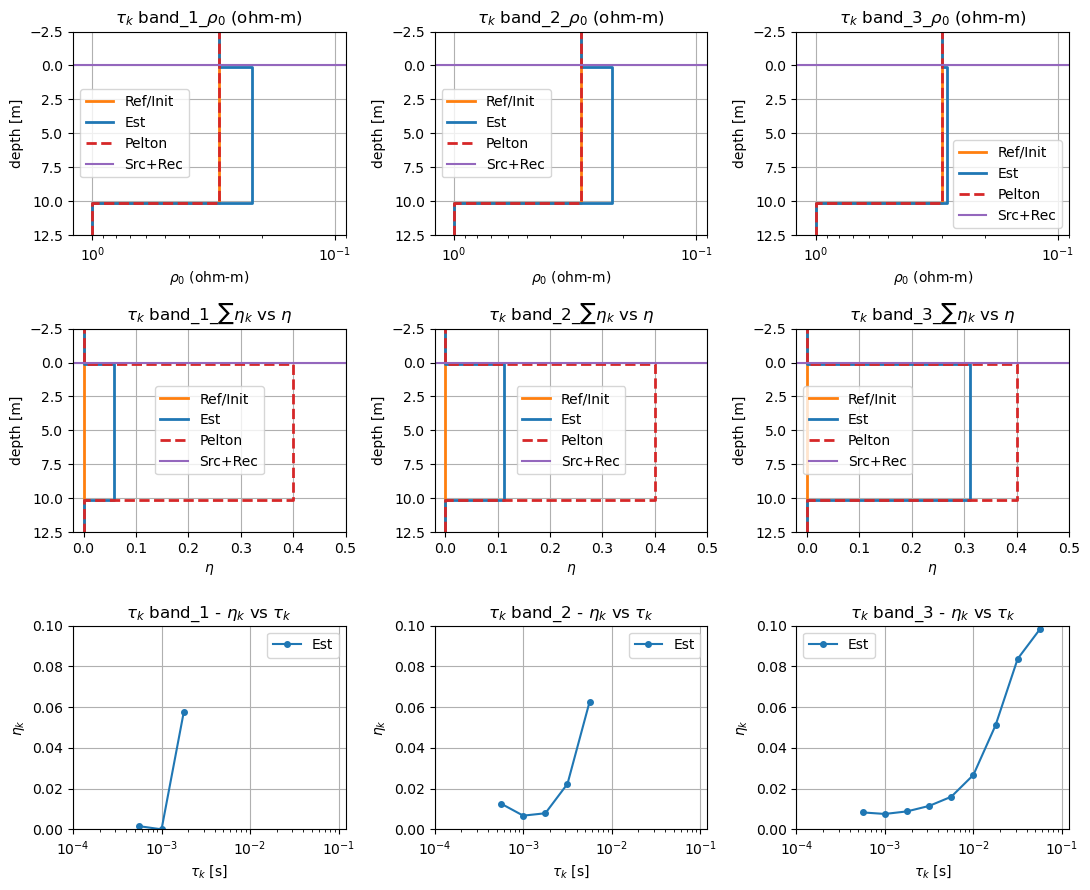

In [49]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nrange):
    title_head = title_heads[i]
    ax_range = ax_ranges[i]
    axrm = ax_range[0:2]
    axetas = ax_range[2]
    sim = sim_sip [i]
    m_ref = m_refs[i]
    axrm = sim_inv[i].plot_IP_par(mvec=m_ref, rm=True,
        label="Ref/Init", color=f"C1", linestyle="-",
        ax=axrm, linewidth=2.0)
    axrm = sim_inv[i].plot_IP_par(mvec=models_rec_phid[i], rm=True,
        label="Est", color=f"C0", linestyle="-", 
        ax=axrm, linewidth=2.0)
    rho0,eta = sim.ip_model.get_rho_eta(models_rec_phid[i])
    # label = fr"Est $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    axetas = plot_etas_model(models_rec_phid[i], taus_cmb[i],
             ax=axetas, color="C0",
             label="Est",
            linestyle="-", marker='o', markersize=4
             )
    # axrm = sim_inv[i].plot_IP_par(mvec=sip_true_inv[i], rm=True,
    #         label="Reconciled", color=f"C2", linestyle=":",
    #         ax=axrm, linewidth=3.0)
    axrm = sim_obs.plot_IP_par(mvec=mvec_obs, rm=True,
            label="Pelton", color=f"C3", linestyle="--",
            ax=axrm, linewidth=2.0)

    rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"Rec $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    # axetas = plot_etas_model(sip_true_inv[i], taus_cmb[i],
    #          ax=axetas, color="C2", label="Rec",
    #          linestyle=":", marker='.', markersize=3)
    axrm[0].invert_xaxis()
    axrm[0].set_xlim([1.2,0.09])
    axrm[1].set_xlim(right=0.5)
    axrm[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axrm[1].set_title(fr"{title_head}_$\sum\eta_k$ vs $\eta$")
    axetas.set_title(fr"{title_head} - $\eta_k$ vs $\tau_k$")
    axetas.set_xlim([1e-4,1.2e-1])
    axetas.set_ylim([0,0.1])
    for j , a in enumerate(axrm):  # Iterate over rows
        a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth [m]')
        if j== 0:
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    for a in (ax_range):
        a.grid()
        a.legend()
\
plt.tight_layout()
plt.savefig('43_Recovered_pelton.jpg', dpi=300)

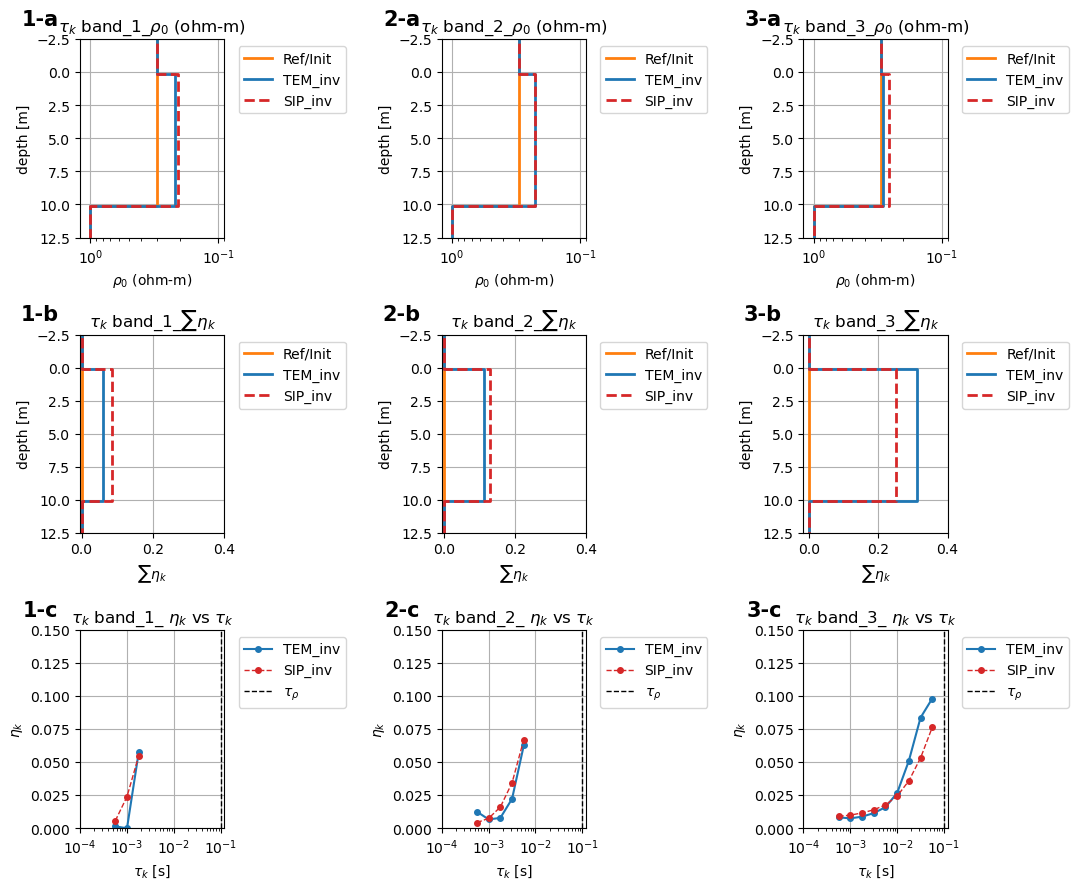

In [50]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nrange):
    title_head = title_heads[i]
    ax_range = ax_ranges[i]
    axrm = ax_range[0:2]
    axetas = ax_range[2]
    sim = sim_sip [i]
    m_ref = m_refs[i]
    axrm = sim_inv[i].plot_IP_par(mvec=m_ref, rm=True,
        label="Ref/Init", color=f"C1", linestyle="-",
        ax=axrm, linewidth=2.0)
    axrm = sim_inv[i].plot_IP_par(mvec=models_rec_phid[i], rm=True,
        label="TEM_inv", color=f"C0", linestyle="-", 
        ax=axrm, linewidth=2.0)
    rho0,eta = sim.ip_model.get_rho_eta(models_rec_phid[i])
    # label = fr"Est $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    axetas = plot_etas_model(models_rec_phid[i], taus_cmb[i],
             ax=axetas, color="C0",
             label="TEM_inv",
            linestyle="-", marker='o', markersize=4
             )
    axrm = sim_inv[i].plot_IP_par(mvec=sip_true_inv[i], rm=True,
            label="SIP_inv", color=f"C3", linestyle="--",
            ax=axrm, linewidth=2.0)

    rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"Rec $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    axetas = plot_etas_model(sip_true_inv[i], taus_cmb[i],
             ax=axetas, color="C3", label="SIP_inv",
             linestyle="--", linewidth=1.0,
             marker='o', markersize=4)
    axrm[0].invert_xaxis()
    axrm[0].set_xlim([1.2,0.09])
    axrm[1].set_xlim(right=0.4)
    axrm[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axrm[1].set_title(fr"{title_head}_$\sum\eta_k$")
    axetas.set_title(fr"{title_head}_ $\eta_k$ vs $\tau_k$")
    label = fr"$\tau_\rho$" 
    axetas.axvline(x=tau_target, color='k', linestyle='--', linewidth=1.0,
                     label=label)
    axetas.set_xlim([1e-4,0.12])
    axetas.set_ylim([0,0.15])
    for j , a in enumerate(axrm):  # Iterate over rows
        # a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        # a.set_ylim([12.5, -2.5])
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth [m]')
        if j== 0:
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    for a in (ax_range):
        a.grid()
        # a.legend()
        a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    column_label = column_labels[i]

    for label, axis in zip(low_names, ax_range):
        axis.text(
            -0.15, 1.05, f"{column_label}{label}",
            transform=axis.transAxes,
            fontsize=15, fontweight='bold',
            va='bottom', ha='right'
        )

plt.tight_layout()
plt.savefig('43_Recovered_DD.jpg', dpi=300)
plt.savefig('43_Recovered_DD.pdf',  bbox_inches="tight")

In [51]:
def sci_latex(v, prec=2):
    s = f"{v:.{prec}e}"          # e.g. '3.00e-03'
    mant, exp = s.split('e')     # '3.00', '-03'
    exp = int(exp)               # remove leading zeros
    if float(mant) == 0:
        return "0"
    if exp == 0:
        return f"{mant}"
    if exp != 0:
        return rf"${mant}\cdot 10^{{{exp}}}$"


In [52]:
ntau_print=[]
sip_inv_print=[]
tem_inv_print=[]
phid_print=[]
taurange_print = []
freqrange_print = []
for i in range(nrange):
    sip_inv_print.append(sip_true_inv[i])
    tem_inv_print.append(models_rec_phid[i])
    ntau_print.append(ntau_cmb[i])
    taurange_print.append(np.r_[taus_strt[i], taus_end[i]])
    freqrange_print.append(np.r_[freq_mins[i], freq_maxs[i]])


In [53]:
rho0_print =[]
eta_print =[]

for i in range(nrange):
    model = np.array(tem_inv_print[i])
    rho0 = np.exp(model[0])
    eta = model[1:].sum()
    rho0_print.append(rho0)
    eta_print.append(eta)
    model = np.array(sip_inv_print[i])
    rho0 = np.exp(model[0])
    eta = model[1:].sum() 
    rho0_print.append(rho0)
    eta_print.append(eta)

names_print=[]
for i in range(nrange):
    names_print.append(f"TEM inv")
    names_print.append(f"SIP inv")
titles_print=[]
for i in range(nrange):
    titles_print.append(rf"$\tau_k$-band {i+1}")

In [54]:

print(r" & \multicolumn{2}{c|}{"
      + r"} & \multicolumn{2}{c|}{".join(f"{v}" for v in titles_print
                                         )
       + r"} \\"
)

print("\hline")

print(r" frequency band & \multicolumn{2}{c|}{"
      + r"} & \multicolumn{2}{c|}{".join(
          " to ".join(sci_latex(v, prec=1) for v in z)
          for z in freqrange_print
      )
       + r"} \\"
)

print("\hline")

print(r" $\tau_k$ band & \multicolumn{2}{c|}{"
      + r"} & \multicolumn{2}{c|}{".join(
          " to ".join(sci_latex(v, prec=1) for v in z)
          for z in taurange_print
      )
       + r"} \\"
)
print("\hline")


print(" n & \multicolumn{2}{c|}{"
      + "} & \multicolumn{2}{c|}{".join(f"{v: }" for v in ntau_print
      )
       + r"} \\"
)

print("   & "
      +" & ".join(f"{v}" for v in names_print
      )
       + r"\\"
)

print(r"$\rho_0$ & "
      +" & ".join(f"{v: .2f}" for v in  rho0_print)
       + r"\\"
)

print(r"$\sum\eta_k$ & "
      +" & ".join(f"{v:.2f}" for v in eta_print)
     + r"\\"
)




 & \multicolumn{2}{c|}{$\tau_k$-band 1} & \multicolumn{2}{c|}{$\tau_k$-band 2} & \multicolumn{2}{c|}{$\tau_k$-band 3} \\
\hline
 frequency band & \multicolumn{2}{c|}{$8.9\cdot 10^{1}$ to $2.8\cdot 10^{2}$} & \multicolumn{2}{c|}{$2.8\cdot 10^{1}$ to $2.8\cdot 10^{2}$} & \multicolumn{2}{c|}{2.8 to $2.8\cdot 10^{2}$} \\
\hline
 $\tau_k$ band & \multicolumn{2}{c|}{$5.6\cdot 10^{-4}$ to $1.8\cdot 10^{-3}$} & \multicolumn{2}{c|}{$5.6\cdot 10^{-4}$ to $5.6\cdot 10^{-3}$} & \multicolumn{2}{c|}{$5.6\cdot 10^{-4}$ to $5.6\cdot 10^{-2}$} \\
\hline
 n & \multicolumn{2}{c|}{ 3} & \multicolumn{2}{c|}{ 5} & \multicolumn{2}{c|}{ 9} \\
   & TEM inv & SIP inv & TEM inv & SIP inv & TEM inv & SIP inv\\
$\rho_0$ &  0.22 &  0.21 &  0.22 &  0.23 &  0.29 &  0.26\\
$\sum\eta_k$ & 0.06 & 0.08 & 0.11 & 0.13 & 0.31 & 0.25\\


In [55]:
chis

[np.float64(6.5569618822893085),
 np.float64(1.035225973406911),
 np.float64(1.0630027645565459)]

save into jsonfile

In [56]:
filename = "43_inv_result.json"
dict_save={}
dict_save = {
    "sip_inv": sip_true_inv,
    "tem_inv": models_rec_phid,
    "ntau_cmb": ntau_cmb,
    "freq_maxs" : freq_maxs,
    "freq_mins": freq_mins,
    "taus_end": taus_end.tolist(),
    "taus_strt": taus_strt.tolist(),
}
with open(filename, "w") as f:
    json.dump(dict_save, f)

TypeError: Object of type ndarray is not JSON serializable

In [ ]:
import numpy as np

def to_jsonable(x):
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, (np.integer, np.floating)):
        return x.item()
    if isinstance(x, dict):
        return {k: to_jsonable(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [to_jsonable(v) for v in x]
    return x

with open(filename, "w") as f:
    json.dump(to_jsonable(dict_save), f, indent=2)
